# ELTE/HDS2022 model

In [1]:
"""Libraries"""

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import numpy as np 
from scipy.integrate import solve_ivp
from scipy.signal import argrelextrema
import time
from numba import jit, njit, prange, float64, float32, int64, int32
import math

In [2]:
"""control parameters"""

# calculate saturated vapour pressure of water
# input temperature in Kelvin, returns pressure in Pascal
@njit(float64(float64))
def VapourPressure(T):    # uses Arden Buck equation
    T -= 273.15
    return 611.21 * np.exp( (18.678 - T / 234.5) * (T / (257.14 + T)) )

# Control parameters
R_E = 4.0e-6                     # Equilibrium radius [m]
ratio = 5.0                      # R_star / R_E [-]
alfa_M = 0.35                    # Accommodation coeff. for evaporation [-]
T_inf = 300.0                    # Ambient temperature [K]
P_inf = 1e5                      # Ambient pressure [Pa]
surfactant = 1.0                 # surface tension modification factor [-]
index = 9                        # index of main gas [Ar: 9; He: 10]
P_v = VapourPressure(T_inf)      # Saturated vapour pressure [Pa]

In [3]:
"""Parameters"""
# From FinalUson2022

# Physical constants Table 1
par_c_L = 1483.0       # Liquid sound speed [m/s]
par_rho_L = 998.2      # Liquid density [kg/m^3]
par_sigma = 71.97e-3   # Surface tension [N/m]
par_mu_L = 0.001       # Dynamic viscosity [Pa*s]
par_R_g = 8.31446      # Universal gas constant [J/mol/K]
par_R_erg = 8.31446e7  # Universal gas constant [erg/mol/K]
par_R_cal = 1.987      # Universal gas constant [cal/mol/K]
par_N_A = 6.02214e23   # Avogadro's number [-]
par_R_v = 461.5227     # Specific gas constant of water [J/kg/K]R_v = R_g / W_water * 1000.0

# Thermodynamic properties Table A.5
par_elements = np.array(["C","H","N","O","Ar","He"])
#                        0     1       2     3       4      5        6       7        8          9      10     11
par_species = np.array(["H",  "H_2",  "O",  "O_2",  "OH",  "H_2O",  "N_2",  "HO_2",  "H_2O_2",  "Ar",  "He",  "OH_{ex}"])
par_W = np.array([       1,    2,      16,   32,     17,    18,      28.02,  33,      34,        39.95, 4,     17], dtype=np.float64) # [g/mol]
par_lambdas = np.array([ 0,    0.1805, 0,    0.02658,0,     0.016,   0,      0,       0.5863,    0.0177,0.151, 0], dtype=np.float64)

par_K = len(par_W)
par_N = 5
par_indexOfWater = 5
par_indexOfArgon = 9
par_indexOfHelium = 10
par_TempRange = np.array([
    #   T_low   T_high    T_mid 
    [   200.0,  6000.0,  1000.0],    # H
    [   200.0,  6000.0,  1000.0],    # H2
    [   200.0,  6000.0,  1000.0],    # O
    [   200.0,  6000.0,  1000.0],    # O2
    [   200.0,  6000.0,  1000.0],    # OH
    [   200.0,  6000.0,  1000.0],    # H2O
    [   200.0,  6000.0,  1000.0],    # N2
    [   200.0,  5000.0,  1000.0],    # HO2
    [   200.0,  6000.0,  1000.0],    # H2O2
    [   200.0,  6000.0,  1000.0],    # AR
    [   200.0,  6000.0,  1000.0],    # HE
    [   300.0,  5000.0,  1000.0]     # OHEX
])

# NASA coefficients Table A.6
par_a_low = np.array([
    #             a_1              a_2              a_3              a_4              a_5              a_6              a_7 
    [             2.5,             0.0,             0.0,             0.0,             0.0,        25473.66,     -0.44668285],    # H
    [      2.34433112,   0.00798052075,  -1.9478151e-05,  2.01572094e-08, -7.37611761e-12,     -917.935173,     0.683010238],    # H2
    [       3.1682671,  -0.00327931884,  6.64306396e-06, -6.12806624e-09,  2.11265971e-12,      29122.2592,      2.05193346],    # O
    [      3.78245636,  -0.00299673416,  9.84730201e-06, -9.68129509e-09,  3.24372837e-12,     -1063.94356,      3.65767573],    # O2
    [      3.99198424,  -0.00240106655,  4.61664033e-06, -3.87916306e-09,  1.36319502e-12,      3368.89836,    -0.103998477],    # OH
    [       4.1986352,   -0.0020364017,   6.5203416e-06,  -5.4879269e-09,    1.771968e-12,      -30293.726,     -0.84900901],    # H2O
    [      3.53100528, -0.000123660988, -5.02999433e-07,  2.43530612e-09, -1.40881235e-12,     -1046.97628,      2.96747038],    # N2
    [      4.30179807,  -0.00474912097,  2.11582905e-05, -2.42763914e-08,  9.29225225e-12,      264.018485,       3.7166622],    # HO2
    [      4.31515149, -0.000847390622,  1.76404323e-05, -2.26762944e-08,  9.08950158e-12,     -17706.7437,      3.27373319],    # H2O2
    [             2.5,             0.0,             0.0,             0.0,             0.0,        -745.375,      4.37967491],    # AR
    [             2.5,             0.0,             0.0,             0.0,             0.0,        -745.375,     0.928723974],    # HE
    [        3.637266,     0.000185091,  -1.6761646e-06,    2.387202e-09,   -8.431442e-13,         50021.3,       1.3588605]     # OHEX
])

par_a_high = np.array([
    #             a_1              a_2              a_3              a_4              a_5              a_6              a_7 
    [             2.5,             0.0,             0.0,             0.0,             0.0,        25473.66,     -0.44668285],    # H
    [      2.93286575,  0.000826608026, -1.46402364e-07,  1.54100414e-11,   -6.888048e-16,     -813.065581,     -1.02432865],    # H2
    [      2.54363697, -2.73162486e-05,  -4.1902952e-09,  4.95481845e-12, -4.79553694e-16,       29226.012,      4.92229457],    # O
    [      3.66096065,  0.000656365811, -1.41149627e-07,  2.05797935e-11, -1.29913436e-15,     -1215.97718,      3.41536279],    # O2
    [      2.83853033,   0.00110741289, -2.94000209e-07,  4.20698729e-11,  -2.4228989e-15,      3697.80808,      5.84494652],    # OH
    [       2.6770389,    0.0029731816,  -7.7376889e-07,   9.4433514e-11,  -4.2689991e-15,      -29885.894,         6.88255],    # H2O
    [      2.95257637,    0.0013969004, -4.92631603e-07,  7.86010195e-11, -4.60755204e-15,     -923.948688,      5.87188762],    # N2
    [      4.17228741,   0.00188117627, -3.46277286e-07,  1.94657549e-11,  1.76256905e-16,      31.0206839,      2.95767672],    # HO2
    [      4.57977305,   0.00405326003,  -1.2984473e-06,    1.982114e-10, -1.13968792e-14,     -18007.1775,     0.664970694],    # H2O2
    [             2.5,             0.0,             0.0,             0.0,             0.0,        -745.375,      4.37967491],    # AR
    [             2.5,             0.0,             0.0,             0.0,             0.0,        -745.375,     0.928723974],    # HE
    [         2.88273,    0.0010139743,   -2.276877e-07,    2.174683e-11,   -5.126305e-16,         50265.0,        5.595712]     # OHEX
])



# Arrhenius-constants Table A.7
par_I = 29    # Number of reactions
par_A  = np.array([5071200000000000.0, 1255400.0, 13193000.0, 84999.0, 4.9806e+18,
                   6165000000000000.0, 4.714e+18, 1.4818e+24, 4650000000000.0, 2123100.0,
                   57734000000000.0, 32500000000000.0, 958400000000.0, 130000000000.0, 1604800000000000.0,
                   214800.0, 24100000000000.0, 9.7543e+19, 9550000.0, 1740000000000.0,
                   75900000000000.0, 15000000000000.0, 5930000000000.0, 2950000000000.0, 108000000000.0,
                   6010000000000.0, 1310000000000.0, 1690000000000.0, 2100000000000.0])    # [cm^3/mol/s v 1/s]

par_b = np.array([-0.48596, 2.27039, 1.87803, 2.26419, -1.21273,
                  -0.5, -1.0, -2.53792, 0.44, 2.1133,
                  0.0, 0.0 ,0.42008, 0.0, 0.0,
                  2.3219, 0.0, -1.92495, 2.0, 0.0,
                  0.0, 0.0, 0.5, 0.5, 0.5,
                  0.5, 0.5, 0.0, 0.5])    # [-]

par_E = np.array([8116.1, 3501.2, 1585.8, -898.23, 308.02,
                  0.0, 0.0, 60.788, 0.0, -817.68,
                  86.07, 0.0, -477.4, -820.33, 7825.6,
                  -1712.31, 1997.99, 4743.4, 1997.99, 160.04,
                  3658.28, 3007.05, -432.81, -223.45, -625.06,
                  -384.5, -84.05, 2081.03, -240.56])    # [cal/mol]

# Reaction matrix
par_nu_forward   =   np.array([
    #   H   H2    O   O2   OH  H2O   N2  HO2 H2O2   AR   HE OHEX 
    [   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],    #  0. H+O2=O+OH
    [   0,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],    #  1. O+H2=H+OH
    [   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],    #  2. OH+H2=H+H2O
    [   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0],    #  3. 2OH=O+H2O
    [   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],    #  4. 2H+M=H2+M
    [   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0],    #  5. 2O+M=O2+M
    [   1,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],    #  6. O+H+M=OH+M
    [   1,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],    #  7. H+OH+M=H2O+M
    [   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],    #  8. H+O2(+M)=HO2(+M)
    [   1,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],    #  9. H+HO2=H2+O2
    [   1,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],    # 10. HO2+H=2OH
    [   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0],    # 11. HO2+O=OH+O2
    [   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0],    # 12. HO2+OH=H2O+O2
    [   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0],    # 13. 2HO2=H2O2+O2
    [   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0],    # 14. 2HO2=H2O2+O2
    [   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0],    # 15. 2OH(+M)=H2O2(+M)
    [   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],    # 16. H2O2+H=H2O+OH
    [   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],    # 17. H2O2+H=H2+HO2
    [   0,   0,   1,   0,   0,   0,   0,   0,   1,   0,   0,   0],    # 18. H2O2+O=OH+HO2
    [   0,   0,   0,   0,   1,   0,   0,   0,   1,   0,   0,   0],    # 19. H2O2+OH=H2O+HO2
    [   0,   0,   0,   0,   1,   0,   0,   0,   1,   0,   0,   0],    # 20. H2O2+OH=H2O+HO2
    [   1,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],    # 21. H+O+M=OHEX+M
    [   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   1],    # 22. OHEX+H2O=OH+H2O
    [   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1],    # 23. OHEX+H2=OH+H2
    [   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   1],    # 24. OHEX+N2=OH+N2
    [   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   1],    # 25. OHEX+OH=2OH
    [   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1],    # 26. OHEX+H=OH+H
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1],    # 27. OHEX+AR=OH+AR
    [   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1]     # 28. OHEX+O2=OH+O2

])   

par_nu_backward   = np.array([
    #   H   H2    O   O2   OH  H2O   N2  HO2 H2O2   AR   HE OHEX 
    [   0,   0,   1,   0,   1,   0,   0,   0,   0,   0,   0,   0],    #  0. H+O2=O+OH
    [   1,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],    #  1. O+H2=H+OH
    [   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],    #  2. OH+H2=H+H2O
    [   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0],    #  3. 2OH=O+H2O
    [   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],    #  4. 2H+M=H2+M
    [   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],    #  5. 2O+M=O2+M
    [   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],    #  6. O+H+M=OH+M
    [   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],    #  7. H+OH+M=H2O+M
    [   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],    #  8. H+O2(+M)=HO2(+M)
    [   0,   1,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],    #  9. H+HO2=H2+O2
    [   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0],    # 10. HO2+H=2OH
    [   0,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0,   0],    # 11. HO2+O=OH+O2
    [   0,   0,   0,   1,   0,   1,   0,   0,   0,   0,   0,   0],    # 12. HO2+OH=H2O+O2
    [   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0],    # 13. 2HO2=H2O2+O2
    [   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0],    # 14. 2HO2=H2O2+O2
    [   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],    # 15. 2OH(+M)=H2O2(+M)
    [   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0],    # 16. H2O2+H=H2O+OH
    [   0,   1,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],    # 17. H2O2+H=H2+HO2
    [   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0],    # 18. H2O2+O=OH+HO2
    [   0,   0,   0,   0,   0,   1,   0,   1,   0,   0,   0,   0],    # 19. H2O2+OH=H2O+HO2
    [   0,   0,   0,   0,   0,   1,   0,   1,   0,   0,   0,   0],    # 20. H2O2+OH=H2O+HO2
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1],    # 21. H+O+M=OHEX+M
    [   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0],    # 22. OHEX+H2O=OH+H2O
    [   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],    # 23. OHEX+H2=OH+H2
    [   0,   0,   0,   0,   1,   0,   1,   0,   0,   0,   0,   0],    # 24. OHEX+N2=OH+N2
    [   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0],    # 25. OHEX+OH=2OH
    [   1,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],    # 26. OHEX+H=OH+H
    [   0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0],    # 27. OHEX+AR=OH+AR
    [   0,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0,   0]     # 28. OHEX+O2=OH+O2
])

par_nu = par_nu_backward - par_nu_forward
for i in range(0, par_I):
    if np.sum(par_nu[i:] *par_W) != 0:
        print('Nonconsistent reaction: ' + str(i) + 'i')

# Third-body efficiencies Table A.8
par_ThirdBodyIndexes=np.array([   4,   5,   6,   7,   8,  15,  21])
par_ThirdBodyCount=len(par_ThirdBodyIndexes)

par_alfa = np.array([
    #       H       H2        O       O2       OH      H2O       N2      HO2     H2O2       AR       HE     OHEX 
    [     1.0,     2.5,     1.0,     1.0,     1.0,    12.0,     1.0,     1.0,     1.0,     1.0,    0.83,     1.0],    #  4. 2H+M=H2+M
    [     1.0,     2.5,     1.0,     1.0,     1.0,    12.0,     1.0,     1.0,     1.0,    0.83,    0.83,     1.0],    #  5. 2O+M=O2+M
    [     1.0,     2.5,     1.0,     1.0,     1.0,    12.0,     1.0,     1.0,     1.0,    0.75,    0.75,     1.0],    #  6. O+H+M=OH+M
    [     1.0,     2.5,     1.0,     1.0,     1.0,    12.0,     1.0,     1.0,     1.0,    0.38,    0.44,     1.0],    #  7. H+OH+M=H2O+M
    [     1.0,   1.511,     1.0,     1.0,     1.0,  11.372,     1.0,     1.0,     1.0,   0.474,    0.65,     1.0],    #  8. H+O2(+M)=HO2(+M)
    [     1.0,    2.47,     1.0,     0.8,     1.0,     5.0,     1.0,     1.0,    5.13,    0.67,    0.43,     1.0],    # 15. 2OH(+M)=H2O2(+M)
    [     1.0,     1.0,     1.0,     0.4,     1.0,     6.5,     0.4,     1.0,     1.0,    0.35,     1.0,     1.0]     # 21. H+O+M=OHEX+M
])

# Pressure-dependency Table A.9
par_PressureDependentIndexes=np.array([   8,  15]) 
par_PressureDependentCount=len(par_PressureDependentIndexes)
par_ReacConst = np.array([
    #               A_0                b_0                E_0 
    [        5.2669e+19,          -1.37367,               0.0],    #  8. H+O2(+M)=HO2(+M)
    [        1.9928e+18,          -1.17797,          -2150.31]     # 15. 2OH(+M)=H2O2(+M)
])

# Pressure-dependency Table A.10
par_Troe = np.array([
    #              alfa               T***                 T*                T** 
    [              0.67,             1e-30,             1e+30,             1e+30],    #  8. H+O2(+M)=HO2(+M)
    [              0.43,             1e-30,             1e+30,             1e+30]     # 15. 2OH(+M)=H2O2(+M)
])

In equilibrium state\
$V_E=\frac{4}{3}R_E^3 \pi$\
$p_E=p_{\infty}+\frac{2 \sigma}{R_E}=p_{H_2O}+p_{Ar}$\
$p_{H_2O}=611.21 \cdot exp\left(\left((18.678-\frac{T\ [°C]}{234.5}\right)\frac{T\ [°C]}{257.14 + T\ [°C]}\right)$\
$n_{Ar}=\frac{p_{Ar} V_E}{R_g T_{\infty}}$\
$V_E=\frac{4}{3}R_E^3 \pi$\
Isotermic expansion from $R_E$ to $R^*$\
$p_{H_2O}^*=p_{H_2O}$\
$n_{Ar}^*=n_{Ar}$\
$n_{H_2O}^*=\frac{p_{H_2O} V^*}{R_g T_{\infty}}$\
$c=\frac{n^*}{V^*}$ both for water and argon\
Required work\
$W=-\int_{V_E}^{V^*}p\ dV + [4 \pi R^2 \sigma]_{R_E}^{R^*}=-\int_{V_E}^{V^*} p_{H_2O} + \frac{n_{Ar}R_g T_{\infty}}{V}\ dV + [4 \pi R^2 \sigma]_{R_E}^{R^*}=$\
$=-\left[ p_{H2O} V + n_{Ar}R_g T_{\infty} ln|V| \right]_{V_E}^{V^*}+ [4 \pi R^2 \sigma]_{R_E}^{R^*}$

In [4]:
"""Inicial condition"""

@njit(float64[:](float64, float64, float64, float64, float64, float64, int32))
def InitialCondition(R_E, ratio, P_inf, T_inf, P_v, surfactant, index):
    IC = np.zeros((par_K+3), dtype=np.float64)
    R_star = ratio * R_E
    
    # Equilibrium state
    p_E = P_inf + 2 * surfactant * par_sigma / R_E # Pa
    V_E = 4.0 / 3.0 * R_E**3 * np.pi    # [m^3]
    p_gas = p_E - P_v
    n_gas = p_gas * V_E / (par_R_g * T_inf)
    
    # Isotermic expansion
    V_star = 4.0 / 3.0 * R_star**3 * np.pi    # [m^3]
    n_H2O = P_v * V_star / (par_R_g * T_inf)
    c_H2O = n_H2O / V_star    # [mol/m^3]
    c_gas = n_gas / V_star    # [mol/m^3]

    # Initial conditions
    IC[0] = R_star   # R_0
    IC[1] = 0.0    # dRdt_0
    IC[2] = T_inf
    IC[3 + par_indexOfWater] = c_H2O * 1.0e-6    # [mol/cm^3]
    IC[3 + index] = c_gas * 1.0e-6    # [mol/cm^3]

    return IC

@njit(float64(float64, float64, float64, float64, float64, float64, int32))
def Work(R_E, ratio, P_inf, T_inf, P_v, surfactant, index):
    R_star = ratio * R_E
    V_E = 4.0 / 3.0 * R_E**3 * np.pi    # [m^3]
    V_star = 4.0 / 3.0 * R_star**3 * np.pi  # [m^3]
    
    p_E = P_inf + 2 * surfactant * par_sigma / R_E # Pa
    p_gas = p_E - P_v
    n_gas = p_gas * V_E / (par_R_g * T_inf)
    
    W_star = -P_v * V_star + n_gas * par_R_g * T_inf * np.log(V_star) + 4.0 * np.pi * par_sigma * surfactant * R_star**2
    W_E = -P_v * V_E + n_gas * par_R_g * T_inf * np.log(V_E) + 4.0 * np.pi * par_sigma * surfactant * R_E**2
    return W_star - W_E    # J

Work(R_E, 5.0, 1e5, T_inf, P_v, 1.0, par_indexOfArgon)
IC = InitialCondition(R_E, 1.0, 1e5, T_inf, P_v, 1.0, par_indexOfArgon)
IC

array([4.00000000e-06, 0.00000000e+00, 3.00000000e+02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.41730755e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.31001636e-05, 0.00000000e+00, 0.00000000e+00])

$p_{\infty }=P_{\infty }+p_A\sin(2\pi f t) \to P_{\infty }$\
$\dot{p_{\infty }}=2\pi fp_A\cos(2\pi f t)\to 0$\
$p=M R_g T=\sum{c_k} R_g T$\
$\dot{p}=\sum{\dot{c_k}} R_g T + \sum{c_k} R_g \dot{T}$\
$\dot{c_k} = \dot{\omega_k} - 3 c_k\frac{\dot{R}}{R}$\
$p_L=p-\frac{2\sigma}{R}-4\mu_L\frac{\dot{R}}{R}$\
$\dot{p_L}=\dot{p}-\frac{2\sigma \dot{R}}{R^2}-4\mu_L\frac{\ddot{R} R - \dot{R}^2}{R^2} \to 
\dot{p_L}=\dot{p}-\frac{2\sigma \dot{R}}{R^2}+4\mu_L(\frac{\dot{R}}{R})^2$\
$\delta=\frac{p_L-p_{\infty}}{\rho_L}$\
$\dot{\delta}=\frac{\dot{p_L}-\dot{p_{\infty}}}{\rho_L}$

In [5]:
@njit(float64[:](float64, float64, float64, float64, float64, float64, float64, float64))
def Pressure(R, R_dot, T, T_dot, M, sum_omega_dot, P_inf, surfactant):
    p_inf = P_inf
    p_inf_dot = 0.0
    p = 0.1 * M * par_R_erg * T
    p_dot = p * (sum_omega_dot / M + T_dot / T - 3.0 * R_dot/R)
    p_L = p - (2.0 * surfactant * par_sigma + 4.0 * par_mu_L * R_dot) / R
    p_L_dot = p_dot + (-2.0 * surfactant * par_sigma * R_dot + 4.0 * par_mu_L * R_dot ** 2) / (R ** 2)
    delta = (p_L - p_inf) / par_rho_L
    delta_dot = (p_L_dot - p_inf_dot) / par_rho_L
    return np.array([delta, delta_dot])

Pressure(IC[0], IC[1], IC[2], 0.0, np.sum(IC[3:]), 0.0, 1e5, 1.0)

array([0., 0.])

In [6]:
"""NASA polynomials"""
# FinalUson2022.pdf equation 6-9

@njit(float64(int32, float64))
def getT_act(k, T):
    if T < par_TempRange[k][0]: # T < T_low
        return par_TempRange[k][0]
    elif T > par_TempRange[k][1]: # T > T_high
        return par_TempRange[k][1]
    else:
        return T

@njit(float64[:](int32, float64))
def getCoeffs(k, T):
    a = np.zeros((7))
    if T < par_TempRange[k][0]: # T < T_low
        a = par_a_low[k]
    elif T > par_TempRange[k][1]: # T > T_high
        a = par_a_high[k]
    elif T <= par_TempRange[k][2]: # T <= T_mid
        a = par_a_low[k]
    else:
        a = par_a_high[k]
    return np.array([a[0], a[1], a[2], a[3], a[4], a[5], a[6]])

@njit(float64[:, :](float64[:], float64))
def Thermodynamic(c, T):
    ret = np.zeros((4, par_K), dtype=np.float64)   # [C_p, H, S, C_v]
    exponent = np.array([1, 2, 3, 4, 5])
    for k in prange(par_K):
    # get coefficients for T
        T_act = getT_act(k, T)
        a = getCoeffs(k, T)
            
     # calculate
        T_vec = T_act ** (exponent-1)    # [1, T, T^2, T^3, T^4]
        # Molar heat capacities at constant pressure (isobaric) [erg/mol/K]
        ret[0][k] = par_R_erg * np.sum(a[:par_N] * T_vec)
        # Enthalpies [erg/mol]
        ret[1][k] = par_R_erg * T_act * (np.sum(a[:par_N] * T_vec / exponent) + a[par_N] / T_act)
        # Entropies [erg/mol/K]
        ret[2][k] = par_R_erg * (a[0] * np.log(T_act) + np.sum(a[1:par_N] * T_vec[1:] / (exponent[1:]-1)) + a[par_N+1])
        # Molar heat capacities at constant volume (isochoric) [erg/mol/K]
    ret[3] = ret[0] - par_R_erg 
    return ret

Thermodynamic(IC[3:], IC[2])[0]

array([2.07861500e+08, 2.88507759e+08, 2.19003039e+08, 2.93880619e+08,
       2.98777325e+08, 3.35964410e+08, 2.91253781e+08, 3.49299827e+08,
       4.24863770e+08, 2.07861500e+08, 2.07861500e+08, 2.99284265e+08])

In [7]:
# FinalUson2022.pdf equation 19-21
@njit(float64[:](float64, float64, float64, float64, float64, float64))
def Evaporation(M, T, X_H2O, alfa_M, T_inf, P_v):
# condensation and evaporation
    p = 0.1 * M * par_R_erg * T
    p_H2O = X_H2O * p
    n_eva_dot = 1.0e3 * alfa_M * P_v / (par_W[par_indexOfWater] * np.sqrt(2.0 * np.pi * par_R_v * T_inf)) # W_H2O=par_W[5] is in g/mol --> *1000
    n_con_dot = 1.0e3 * alfa_M * p_H2O / (par_W[par_indexOfWater] * np.sqrt(2.0 * np.pi * par_R_v * T))
    n_net_dot = n_eva_dot - n_con_dot
# Molar heat capacity of water at constant volume (isochoric) [erg/mol/K]
    exponent = np.array([1, 2, 3, 4, 5])
    T_act = getT_act(5, T)
    a = getCoeffs(5, T)
    T_vec = T_act ** (exponent-1)    # [1, T, T^2, T^3, T^4]
    C_v = par_R_erg * (np.sum(a[:par_N] * T_vec) - 1.0)
    T_act = getT_act(5, T_inf); a = getCoeffs(5, T_inf)
    T_vec = T_act ** (exponent-1)    # [1, T, T^2, T^3, T^4]
    C_v_inf = par_R_erg * (np.sum(a[:par_N] * T_vec) - 1.0)
# Evaporation energy
    e_eva = C_v_inf * T_inf * 1e-7   # J/mol
    e_con = C_v * T * 1e-7
    evap_energy = n_eva_dot * e_eva - n_con_dot * e_con    # W/m^2
    return np.array([n_net_dot, evap_energy])

X_H2O = IC[8] / np.sum(IC[3:])
Evaporation(np.sum(IC[3:]), IC[2], X_H2O, alfa_M, T_inf, P_v)

array([1.42108547e-14, 1.16415322e-10])

In [8]:
# FinalUson2022.pdf equation 21, 35-43
@njit(float64[:](float64, float64[:]))
def ForwardRate(T, M):
# Reaction rate, equation 21
    k_forward = par_A * T ** par_b * np.exp(-par_E / (par_R_cal * T))
    
# Pressure dependent reactions, equations 35-43
    for j, i in enumerate(par_PressureDependentIndexes):    # i is the number of reaction, j is the index of i's place in par_PressureDependentIndexes
        k_inf = k_forward[i]    # par_A[i] * T ** par_b[i] * np.exp(-par_E[i] / (par_R_cal * T))
        k_0 = par_ReacConst[j][0] * T ** par_ReacConst[j][1] * np.exp(-par_ReacConst[j][2] / (par_R_cal * T))
        P_r = k_0 / k_inf * M[i]
        logP_r = np.log10(P_r)
        
        # Keep in mind, some T** values are not used (if they are 0.0, not here)
        F_cent = (1.0 - par_Troe[j][0]) * np.exp(-T / par_Troe[j][1]) + par_Troe[j][0] * np.exp(-T / par_Troe[j][2]) + np.exp(-par_Troe[j][3] / T)
        logF_cent = np.log10(F_cent)
        c = -0.4 - 0.67 * logF_cent
        n = 0.75 - 1.27 * logF_cent
        d = 0.14
        logF = 1.0 / (1.0 + ((logP_r + c) / (n - d * (logP_r + c))) ** 2) * logF_cent
        F = 10.0 ** logF
        
        k_forward[i] = k_inf * P_r / (1.0 + P_r) * F
    return k_forward
        
M = np.sum(IC[3:]) * np.ones((par_I))    # effective total concentration of the third-body species
for j, i in enumerate(par_ThirdBodyIndexes):
    M[i] = np.sum(par_alfa[j] * IC[3:]) 
ForwardRate(IC[2], M)[:10]

array([3.87493930e+08, 1.48586710e+09, 4.14096444e+10, 1.55776247e+11,
       2.94300787e+15, 3.55936441e+14, 1.57133333e+16, 6.91458825e+17,
       7.62065345e+11, 1.43747253e+12])

In [9]:
# FinalUson2022.pdf equation 28-32
@njit(float64[:](float64[:], float64[:], float64[:], float64, float64))
def BackwardRate(k_forward, S, H, T, P_inf):
    DeltaS = np.sum(par_nu * S, axis=1)
    DeltaH = np.sum(par_nu * H, axis=1)
    K_p = np.exp(DeltaS / par_R_erg - DeltaH / (par_R_erg * T))
    K_c = K_p * (P_inf * 10.0 / (par_R_erg * T)) ** np.sum(par_nu, axis=1)
    k_backward = k_forward / K_c
    return k_backward

[C_p, H, S, C_v] = Thermodynamic(IC[3:], IC[2])
M = np.sum(IC[3:]) * np.ones((par_I))    # effective total concentration of the third-body species
for j, i in enumerate(par_ThirdBodyIndexes):
    M[i] = np.sum(par_alfa[j] * IC[3:]) 
k_f = ForwardRate(IC[2], M)
BackwardRate(k_f, S, H, IC[2], 1e5)[:10]

array([1.61661311e+19, 7.71700830e+09, 3.48307930e+00, 2.52286549e+00,
       2.08091360e-60, 3.13301799e-71, 5.77032070e-59, 4.11235701e-68,
       2.57491296e-24, 3.00809702e-28])

In [10]:
# FinalUson2022.pdf equation 23-43
@njit(float64[:](float64, float64[:], float64[:], float64[:], float64))
def ProductionRate(T, H, S, c, P_inf):
    # equation 34
    M = np.sum(c) * np.ones((par_I))    # effective total concentration of the third-body species
    for j, i in enumerate(par_ThirdBodyIndexes):
        M[i] = np.sum(par_alfa[j] * c) 
    
    k_forward = ForwardRate(T, M)
    k_backward = BackwardRate(k_forward, S, H, T, P_inf)

# Net rate, equation 23
    q = np.zeros((par_I))
    for i in prange(par_I):
        q[i] = k_forward[i] * np.prod(c ** par_nu_forward[i]) - k_backward[i] * np.prod(c ** par_nu_backward[i])
# Three body reactions, equation 33-34
    for j, i in enumerate(par_ThirdBodyIndexes):    # i is the number of reaction, j is the index of i in par_ThirdBodyIndexes
        if i not in par_PressureDependentIndexes:
            q[i] *= M[i]
# Production rate, equation 24
    omega_dot = np.zeros((par_K))
    for k in prange(par_K):
        omega_dot[k] = np.sum(par_nu[:, k] * q)
    
    return omega_dot
    
[C_p, H, S, C_v] = Thermodynamic(IC[3:], IC[2],)
ProductionRate(IC[2], H, S, IC[3:], 1e5)

array([ 2.16736217e-78,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.16736217e-78, -2.16736217e-78,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

$\vec{x}=[R, \dot{R}, T, c_1, c_2, ...]$\
where $c_k$ is the molar concentration in $[\frac{mol}{cm^3}]$\
$(1-\frac{\dot{R}}{c_L})R \ddot{R}+(1-\frac{\dot{R}}{3 c_L})\frac{3}{2} \dot{R}^2=(1+\frac{\dot{R}}{c_L}+\frac{R}{c_L}\frac{d }{dt})\frac{p_L-p_{\infty }}{\rho_L}$
* $\frac{dR}{dt}=\dot{R}$
* $\frac{d\dot{R}}{dt}=\frac{Nom}{Den}$\
$Nom=(1+\frac{\dot{R}}{c_L})\frac{p_L-p_{\infty}}{\rho_L}+\frac{R}{\rho_L c_L}(\dot{p_L}-\dot{p_{\infty}}) 
- (\frac{3}{2}-\frac{\dot{R}}{2 c_L})\dot{R}^2$\
$Den=(1-\frac{\dot{R}}{c_L})R + \frac{4 \mu_L}{c_L \rho_L}$
* $\dot{T}= \frac{-p\dot{V} + \sum{\dot{Q}}}{n_t \overline{C_v}}$
* $\dot{c}_k = \dot{\omega}_k - 3 c_k \frac{\dot{R}}{R}$ &nbsp;&nbsp;&nbsp;
$(k=1..K)$ expect for water
* $\dot{c}_{H_2O} = \dot{\omega}_{H_2O} - 3 c_{H_2O} \frac{\dot{R}}{R} +
\dot{n}_{net} \frac{3}{R}$ for water

In [11]:
"""Differential Equation"""
enable_heat_transfer = True
enable_evaporation = True
enable_evap_energy = True
enable_reactions = True

@njit(float64[:](float64, float64[:], float64, float64, float64, float64, float64))
def DE(t, x, alfa_M, T_inf, P_v, P_inf, surfactant):    
    R = x[0]      # bubble radius [m]
    R_dot = x[1]   
    T = x[2]      # temperature [K]
    c = x[3:]     # molar concentration [mol/cm^3]
    M = np.sum(c) # sum of concentration
    X = c / M     # mole fraction
    dxdt = np.zeros(x.shape, dtype = np.float64)
    
# d/dt R
    dxdt[0] = R_dot
# Evaporation
    n_net_dot = 0.0  
    evap_energy = 0.0
    if enable_evaporation:
        n_net_dot, evap_energy = Evaporation(M, T, X[par_indexOfWater], alfa_M, T_inf, P_v)
    if not enable_evap_energy:
        evap_energy = 0.0
# Thermodynamics
    # equation 11-14
    [C_p, H, S, C_v] = Thermodynamic(c, T)
    W_avg = np.sum(X * par_W)
    rho_avg = W_avg * M #np.sum(c * par_W)
    C_p_avg = np.sum(X * C_p)
    C_v_avg = np.sum(X * C_v)
    # equation 15-18
    lambda_avg = np.sum(X * par_lambdas)
    chi_avg = 10.0 * lambda_avg * W_avg / (C_p_avg * rho_avg)
    l_th = np.inf
    if R_dot != 0.0:
        l_th = np.sqrt(R * chi_avg / abs(R_dot))
    l_th = min(l_th, R / np.pi)
    Q_th_dot = 0.0
    if enable_heat_transfer:
        Q_th_dot = lambda_avg * (T_inf - T) / l_th
# Reactions, equations 44-45
    omega_dot = np.zeros((par_K))    
    if enable_reactions:
        omega_dot = ProductionRate(T, H, S, c, P_inf)
    c_dot = omega_dot - c * 3.0 * R_dot / R
    c_dot[par_indexOfWater] += 1.0e-6 * n_net_dot * 3.0 / R    # water evaporation
    M_dot = np.sum(c_dot)
    dxdt[3:] = c_dot
# d/dt T
    # equation 25-26
    Q_r_dot = -np.sum(H * omega_dot)
    #sumQ_dot = Q_th_dot + Q_r_dot
    
    p = 0.1 * M * par_R_erg * T
    n_t = M * 4.0/3.0 * np.pi * R ** 3    # molar concentration
    T_dot = (Q_r_dot + 30.0 / R * (-p * R_dot + Q_th_dot + evap_energy)) / (M * C_v_avg)
    dxdt[2] = T_dot
# d/dt R_dot
    [delta, delta_dot] = Pressure(R, R_dot, T, T_dot, M, np.sum(omega_dot), P_inf, surfactant)   # delta = (p_L-p_inf) / rho_L
    Nom = (1.0 + R_dot / par_c_L) * delta + R / par_c_L * delta_dot - (1.5 - 0.5 * R_dot / par_c_L) * R_dot ** 2
    Den = (1.0 - R_dot / par_c_L) * R + 4.0 * par_mu_L / (par_c_L * par_rho_L)
    
    dxdt[1] = Nom / Den
    
    return dxdt

DE(0.0, IC, alfa_M, T_inf, P_v, 1e5, 1.0)

array([0.00000000e+00, 3.82721861e-11, 1.25073560e-07, 2.16736217e-78,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.16736217e-78,
       1.06581410e-14, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [12]:
"""Extract datas"""
datalist = [
    'ID', 'error code [0, 1, 2]', 'steps [-]', 'runtime [s]',
    'R_E [m]', 'R_0/R_E [-]', 'P_inf [Pa]', 'alfa_M [-]', 'T_inf [K]', 'vapour pressure [Pa]', 'index [Ar: 9; He: 10]', 'surfactant [-]',
    'T_max [K]', 'collapse time [s]', 'n_H2 [mol]', 'n_O2 [mol]', 'Work [Joule]', 'Energy [MJ/kg]',
    'R_last [m]', 'R_dot_last', 'T_last [k]', 'c_H [mol/cm^3]',  'c_H2 [mol/cm^3]',  'c_O [mol/cm^3]', 
    'c_O2 [mol/cm^3]',  'c_OH [mol/cm^3]',  'c_H2O [mol/cm^3]',  'c_N2 [mol/cm^3]',  'c_HO2 [mol/cm^3]', 
    'c_H2O2 [mol/cm^3]',  'c_Ar [mol/cm^3]',  'c_He [mol/cm^3]',  'c_OHex [mol/cm^3]'
]

def getData(num_sol, R_E, ratio, P_inf, alfa_M, T_inf, P_v, index, surfactant, ID, elapsed, error):
    last_y = num_sol.y[:, -1]
    T_max = np.max(num_sol.y[:][2])
    loc_min = argrelextrema(num_sol.y[:][0], np.less)
    collapse_time = 0.0
    if not len(loc_min[0]) == 0:
        collapse_time = num_sol.t[loc_min[0][0]]
    last_V = 4.0 / 3.0 * (100.0 * last_y[0]) ** 3 * np.pi    # [cm^3]
    n_H2 = last_y[4] * last_V
    n_O2 = last_y[6] * last_V
    m_H2 = 1e-3 * n_H2 / par_W[2]    # [kg]
    W = Work(R_E, ratio, P_inf, T_inf, P_v, surfactant, par_indexOfArgon)    # [J]
    energy = 1e-6 * W / m_H2    # [MJ/kg]

    data = [
        ID, error, len(num_sol.y[:][0]), elapsed, 
        R_E, ratio, P_inf, alfa_M, T_inf, P_v, index, surfactant,
        T_max, collapse_time, n_H2, n_O2, W, energy,
    ]
    for d in last_y:
        data.append(d)
        
    return data

def printData(data):
    for prop, value in zip(datalist, data):
        prop += ':'
        print(f'{prop:<{25}}' + f'{value}')

In [13]:
"""Plot"""

def plot(num_sol, parameter, saveit):
    [ID, R_E, ratio, P_inf, alfa_M, T_inf, P_v, index, surfactant] = parameter
# Calculations
    loc_min = argrelextrema(num_sol.y[:][0], np.less)
    collapse_time = 0.0
    if not len(loc_min[0]) == 0:
        collapse_time = num_sol.t[loc_min[0][0]]
    end_index = -1000#np.where(num_sol.t > 5.0*collapse_time)[0][0]
    
    t = num_sol.t[:end_index]
    R = num_sol.y[0, :end_index]
    R_dot = num_sol.y[1, :end_index]
    T = num_sol.y[2, :end_index]
    c = num_sol.y[3:, :end_index] # mol/m^3

    V = 4.0 / 3.0 * (100.0 * R) ** 3 * np.pi # m^3
    n = c * V

    # plot R and T
    fig = plt.figure(figsize=(20, 6))
    ax1 = fig.add_subplot(axisbelow=True)

    ax2 = ax1.twinx()
    ax1.plot(t, R / R_E, label = "R [m]", color = 'b', linewidth = 1.0)
    ax2.plot(t, T, label = "T [K]", color = 'r', linewidth = 1.0, linestyle = '-.')

    ax1.set_ylabel('$y1$ [-]')
    ax1.set_xlabel('$t$ [s]')
    ax1.set_ylabel('$R/R_E$ [-]', color = 'b')
    ax2.set_ylabel('$T$ [K]', color = 'r')
    ax1.grid()
    
    gas = 'Argon' if index==par_indexOfArgon else 'Hydrogen'
    text = f"""
    Initial conditions:
      {'$R_E$':<25} {1e6*R_E: .2f}  $[\mu m]$
      {'$R_0/R_E$':<25} {ratio: .2f}  $[-]$
      {'$P_∞$':<25} {1e-5*P_inf: .2f}  $[bar]$
      {'$α_M$':<25} {alfa_M: .2f}  $[-]$
      {'$T_∞$':<25} {T_inf-273.15: .2f}  $[°C]$
      {'$P_{vapour}$':<25} {P_v: .1f}  $[Pa]$
      {'$ambient$ $gas$':<25} {gas}
      {'$surfactant$':<25} {surfactant: .2f}  $[-]$
    """
    ax1.text(
        0.75, 0.95, text, transform=ax1.transAxes, horizontalalignment='left', verticalalignment='top', fontsize=16, fontstyle='oblique',
        bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 10},
    )
    
    plt.show()
    if saveit:
        fig.savefig('images/plot_R.png')

    # plot reactions
    fig = plt.figure(figsize=(20, 9))
    ax = fig.add_subplot(axisbelow=True)

    plt.ylim([1e-23, 1e-11])
    ax.set_yscale('log')
    #O,    H,    H2,     OH,   O2,      H2O,   HO2, H2O2,   O3,  OH_ex
    for i, element in enumerate(par_species):
        ax.plot(t, n[i], label = '$' + element + '$', linewidth = 1.0)

    ax.set_xlabel('$t$ [s]')
    ax.set_ylabel('$n_k$ [mol]')
    ax.grid()
    ax.legend()

    plt.show()
    if saveit:
        fig.savefig('images/plot_mol.png')

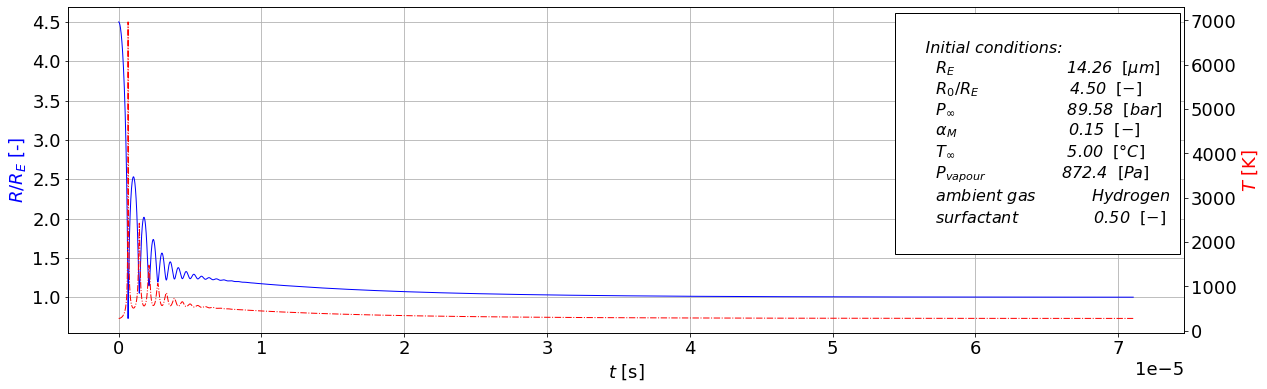

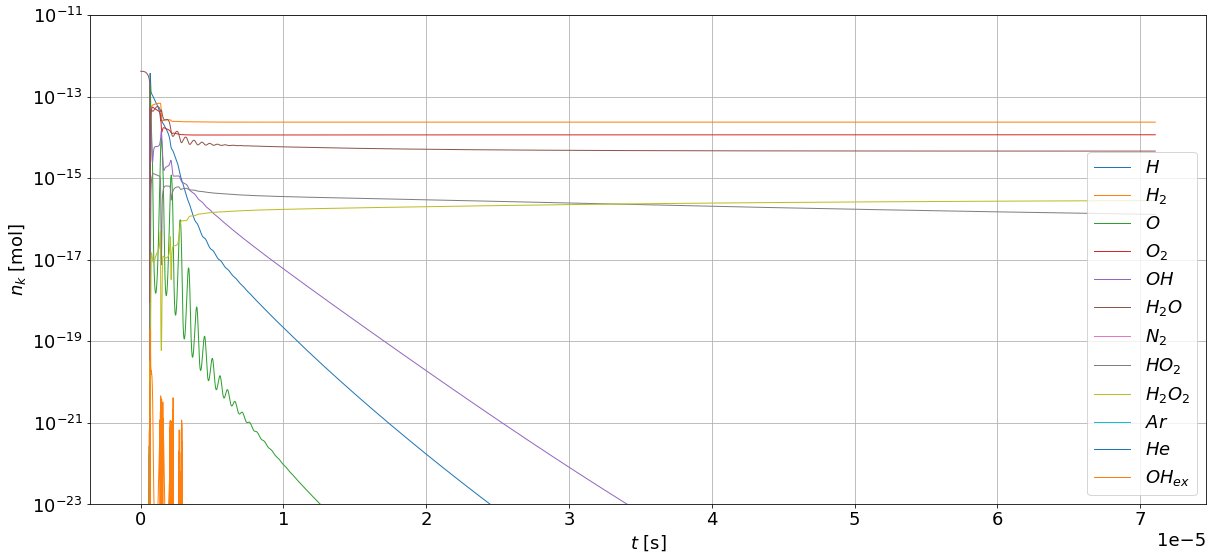

ID:                      0
error code [0, 1, 2]:    0
steps [-]:               12222
runtime [s]:             1.609375
R_E [m]:                 1.4263157894736843e-05
R_0/R_E [-]:             4.5
P_inf [Pa]:              8957894.736842105
alfa_M [-]:              0.15
T_inf [K]:               278.15
vapour pressure [Pa]:    872.4400336372915
index [Ar: 9; He: 10]:   10.0
surfactant [-]:          0.5
T_max [K]:               6966.676504173304
collapse time [s]:       6.581338598765411e-07
n_H2 [mol]:              2.3598159544213257e-14
n_O2 [mol]:              1.1625997238750242e-14
Work [Joule]:            4.923286076045253e-07
Energy [MJ/kg]:          333808.13901667454
R_last [m]:              1.4266748364940257e-05
R_dot_last:              4.288691480920817e-15
T_last [k]:              278.14999999980705
c_H [mol/cm^3]:          3.346775378083668e-27
c_H2 [mol/cm^3]:         1.9400571337022357e-06
c_O [mol/cm^3]:          2.4612120544929955e-28
c_O2 [mol/cm^3]:         9.55799067176

In [18]:
"""Solve"""
parameter = [0.0, 1.4263157894736843e-05, 4.5, 8957894.736842105, 0.15, 278.15, 872.4400336372915, 10.0, 0.5]#[362940.0, 3e-06, 10.0, 10e5, 0.35, 303.15, 4245.12571625229, 9.0, 1.0]
[ID, R_E, ratio, P_inf, alfa_M, T_inf, P_v, index, surfactant] = parameter
IC = InitialCondition(R_E, ratio, P_inf, T_inf, P_v, surfactant, index)
t_int = np.array([0.0, 1.0])

# Számolás
error = 0
ID = 0
start = time.process_time()
try:
    num_sol = solve_ivp(DE, t_int, IC, method='LSODA', atol = 1e-10, rtol=1e-10, args=(alfa_M, T_inf, P_v, P_inf, surfactant))
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
    if num_sol.success == False: error = 1
except:
    error = 1
if error == 1:
    try:
        num_sol = solve_ivp(DE, t_int, IC, method='Radau', atol = 1e-10, rtol=1e-10, args=(alfa_M, T_inf, P_v, P_inf, surfactant))
        if num_sol.success == False: error = 2
    except:
        error = 2

end = time.process_time()
elapsed = (end - start)

data = getData(num_sol, R_E, ratio, P_inf, alfa_M, T_inf, P_v, index, surfactant, ID, elapsed, error)
plot(num_sol, parameter, True)
printData(data)